### TFIDF --> Feedforward Neural Network

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
valid = pd.read_csv("valid.csv")

train.loc[train["review_score"]==-1, "review_score"]=0
test.loc[test["review_score"]==-1, "review_score"]=0
valid.loc[valid["review_score"]==-1, "review_score"]=0

In [2]:
train["review_score"].value_counts()

review_score
0    21615
1    21615
Name: count, dtype: int64

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43230 entries, 0 to 43229
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    43230 non-null  int64 
 1   review_text   43230 non-null  object
 2   review_score  43230 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1013.3+ KB


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

input_vectorizer = TfidfVectorizer(stop_words="english",strip_accents="ascii",max_features=4096, norm="l1")

In [5]:
input_vectorizer = input_vectorizer.fit(train["review_text"])

In [72]:
train["vectorized"] = train["review_text"].apply(lambda x : input_vectorizer.transform([x]).toarray()[0])

In [73]:
train["review_text"].iloc[0]

"I'm the biggest fan you will ever meet of tile-based rpgs.  Lands of Lore! Eye of the Beholder! YES!!  I've been playing Xeen since '92. Why doesn't someone make a game like that again?!!  No seriously, let me know if you see one, because that's what this game seems to be going for but it sadly misses the mark.   I would be more forgiving and I would even give this game a positive except that the mis-steps they took are downright bewildering.  First what do I love about this title... It really is incredibly challenging. The puzzles, battles, and resource management is unforgiving which is a nice throwback to the 'good old days'. I love that they took that risk here, because usually it makes the difference between a grind and compelling, rewarding gameplay. Grimrock is a nice reminder of the days when games weren't all just an endurance contest, and not everyone could beat every game given enough time.  The first thing you'll notice is that this game is fun. Actually, really fun. You c

In [74]:
train["vectorized"].iloc[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [75]:
np.count_nonzero(train["vectorized"].iloc[0])

199

In [50]:
test["vectorized"] = test["review_text"].apply(lambda x : input_vectorizer.transform([x]).toarray()[0])
valid["vectorized"] = valid["review_text"].apply(lambda x : input_vectorizer.transform([x]).toarray()[0])

After a couple attempts where the model's predictive quality were very low, I added one more layer and increased the number of neurons in hidden layers. I also increased the size of the tf-idf embeddings to 4096. After these changes the model's performance greatly improved.

In [77]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import Adam

def create_model():
    inputs = keras.Input(shape=(4096,))
    dense1 = layers.Dense(1024, activation="relu")(inputs)
    dense2 = layers.Dense(512, activation="relu")(dense1)
    dense3 = layers.Dense(128, activation="relu")(dense2)
    output = layers.Dense(1, activation="sigmoid")(dense3)
    model = keras.Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    return model

In [78]:
train["vectorized"].iloc[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [79]:
train["review_score"].iloc[0]

0

In [80]:
train_x = np.stack(train["vectorized"].values)
train_y = np.stack(train["review_score"].values)

valid_x = np.stack(valid["vectorized"].values)
valid_y = np.stack(valid["review_score"].values)

test_x = np.stack(test["vectorized"].values)
test_y = np.stack(test["review_score"].values)

In [81]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model = create_model()
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=25, callbacks=[callback])

Epoch 1/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.4557 - accuracy: 0.7972 - val_loss: 0.4194 - val_accuracy: 0.8150
Epoch 2/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.3468 - accuracy: 0.8525 - val_loss: 0.3864 - val_accuracy: 0.8257
Epoch 3/25
1351/1351 [==============================] - 16s 12ms/step - loss: 0.3006 - accuracy: 0.8706 - val_loss: 0.3710 - val_accuracy: 0.8488
Epoch 4/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.2564 - accuracy: 0.8908 - val_loss: 0.4160 - val_accuracy: 0.8260
Epoch 5/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.2038 - accuracy: 0.9153 - val_loss: 0.4832 - val_accuracy: 0.8182
Epoch 6/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.1435 - accuracy: 0.9416 - val_loss: 0.5748 - val_accuracy: 0.8140
Epoch 7/25
1351/1351 [==============================] - 15s 11ms/step - loss: 0.0967 - accuracy: 0.9598 - val_loss: 0.7156 -

### Towards the end of the training the model suffered from overfitting:

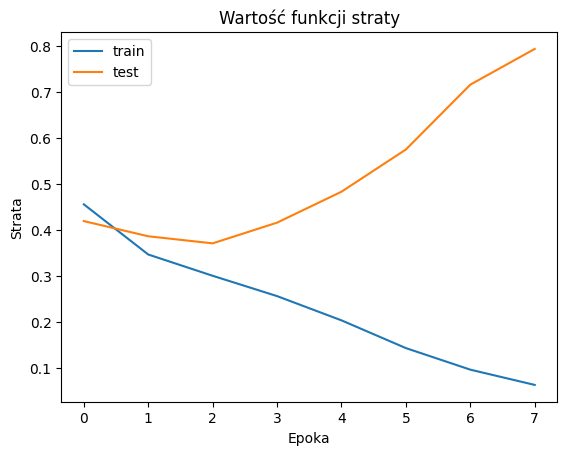

In [84]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wartość funkcji straty')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['train', 'test'], loc='upper left')

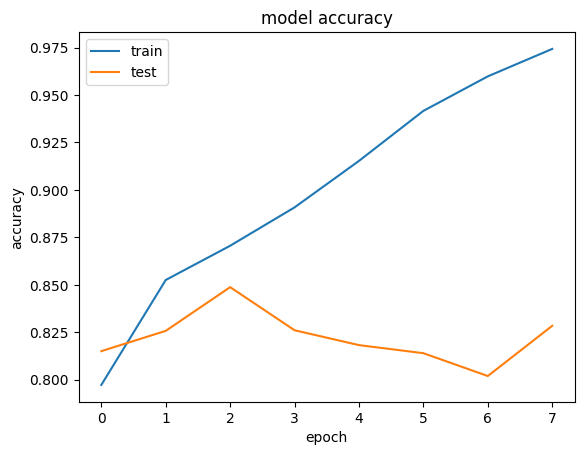

In [85]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [86]:
model.save("tfidf_model.keras")

In [7]:
import keras
model = keras.models.load_model('tfidf_model.keras')

In [37]:
import tensorflow as tf
def test_review_text(sentence):
    vectorized = input_vectorizer.transform([sentence]).toarray()[0]
    reshaped = tf.reshape(vectorized,shape=(1,4096))
    #print(vectorized.shape)
    score = float(model(reshaped))
    score_rounded = round(score)
    print(score)
    if score_rounded==0:
        print("Negative review")
    else:
        print("Positive review")

In [47]:
test_review_text("A buggy, uninspired mess")

0.0009309111046604812
Negative review


In [39]:
test_review_text("This game is bad")

0.31012997031211853
Negative review


In [40]:
test_review_text("This game destroyed my life")

0.7850202918052673
Positive review


In [41]:
test_review_text("Best game I've ever played")

0.9888448715209961
Positive review


In [45]:
test_review_text("Fun cooperative play with scalable difficulty. Rapid path to get into a game with friends or open public games. ")

0.7033981680870056
Positive review


In [46]:
test_review_text("Deliriously buggy. Fun if/when it works properly. Wait and see if they actually QA the next few patches before you play.")

0.2961832880973816
Negative review


In [52]:
test["model_predictions"] = model(np.stack(test["vectorized"].values))

In [53]:
test["model_predictions"] = test["model_predictions"].apply(lambda x : round(float(x)))

In [57]:
def get_metrics():
    df = test
    predictions = df["model_predictions"].to_numpy()
    true_values = df["review_score"].to_numpy()
    accuracy = np.sum(np.rint(predictions) == true_values)/len(true_values)
    TN_count = len(df.query("`review_score`==0 and `model_predictions`==0").index)
    TP_count = len(df.query("`review_score`==1 and `model_predictions`==1").index)
    FP_count = len(df.query("`review_score`==0 and `model_predictions`==1").index)
    FN_count = len(df.query("`review_score`==1 and `model_predictions`==0").index)
    precision = TP_count/(TP_count+FP_count)
    recall = TP_count/(TP_count+FN_count)
    F1_score = (2*precision*recall)/(precision+recall)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {F1_score:.2f}")
get_metrics()

Accuracy: 0.85
Precision: 0.96
Recall: 0.86
F1 Score: 0.90
